## TO DO:

<input id="cb1" type="checkbox"  /> Switch to LightGBM?

<input id="cb1" type="checkbox"  /> Tune hyper-params

<input id="cb1" type="checkbox"  /> Investigate stacking (https://www.kaggle.com/competitions/ieee-fraud-detection/discussion/111308)

<input id="cb1" type="checkbox"  /> Investigate SMOTE (imbalance-learn)

<input id="cb1" type="checkbox"  /> Clean up EDA

<input id="cb1" type="checkbox"  /> Review IAS about page

<input id="cb1" type="checkbox" checked /> Double check AUC plot generation

<input id="cb1" type="checkbox" checked /> `generate_submission()` needs to include opening pickled DF created in each fold and taking the mean of all of them

<input id="cb1" type="checkbox" checked /> Create score csv and automate updating


# Prelim

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import os
import json
import pickle
import glob

from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_sample_weight

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)             

In [5]:
train_identity      = pd.read_csv('data/train_identity.csv')
train_transaction   = pd.read_csv('data/train_transaction.csv')
train               = train_transaction.merge(train_identity, on='TransactionID', how='outer')
del train_transaction, train_identity

In [6]:
# Feature subsets for easy reference
COLUMNS     = list( train.columns ) 

V           = [x for x in COLUMNS if re.match('V+[0-9]*', x)]
C           = [x for x in COLUMNS if re.match('C+[0-9]*', x)]
D           = [x for x in COLUMNS if re.match('D+[0-9]*', x)]
M           = [x for x in COLUMNS if re.match('M+[0-9]*', x)]
ID          = [x for x in COLUMNS if re.match('id+_+[0-9]*', x)]
CARD        = [x for x in COLUMNS if re.match('card+[0-9]*', x)]

CATEGORIES  = list(train.select_dtypes(exclude=np.number).columns)
NUMBERS     = list(train.select_dtypes(include=np.number).columns)

OTHER       = list( set(COLUMNS) - set(V + C + D + M + ID + CARD) )
OTHER.remove('isFraud')

nadf = pd.DataFrame(train.isna().sum())
NA05 = list(nadf[nadf[0] > (0.05 * len(train))].index) # List of columns who are missing more than 5% entries 

FEATURE_CLASSES = {
    'V':           V, 
    'C':           C, 
    'D':           D ,
    'M':           M, 
    'ID':          ID,
    'CARD':        CARD,
    'OTHER':       OTHER
}

# EDA

In [6]:
print('Percentage of train set that is fraudulent:', 100 * len( train[train['isFraud'] > 0] ) / len(train))

Percentage of train set that is fraudulent: 3.499000914417313


In [13]:
nancount = pd.DataFrame( train.isna().sum() / len(train) )
nancount = nancount[nancount[0] > 0.90]
nancount = nancount.transpose()
nancount

,dist2,D7,id_07,id_08,id_18,id_21,id_22,id_23,id_24,id_25,id_26,id_27
0,0.936284,0.934099,0.991271,0.991271,0.923607,0.991264,0.991247,0.991247,0.991962,0.99131,0.991257,0.991247


In [15]:
train[CATEGORIES]

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,...,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,W,visa,debit,outlook.com,NaN,T,T,T,M0,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,M0,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,...,Android 7.0,samsung browser 6.2,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,W,visa,debit,NaN,NaN,T,T,T,M0,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,W,mastercard,debit,gmail.com,NaN,T,F,F,M0,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,W,mastercard,debit,gmail.com,NaN,T,F,F,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,W,mastercard,debit,aol.com,NaN,T,T,T,M0,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
train['id_34'].value_counts()

id_34
match_status:2     60011
match_status:1     17376
match_status:0       415
match_status:-1        3
Name: count, dtype: int64

In [ ]:
tmp = ID + ['isFraud']

ID_fraud_props = train[tmp].groupby('isFraud').count() / train[tmp].groupby('isFraud').count().sum()

In [43]:
ID_fraud_props.sort_values(0, axis=1, ascending=True).iloc[:, :20]

,id_04,id_03,id_10,id_09,id_24,id_13,id_18,id_07,id_08,id_21,id_22,id_23,id_27,id_26,id_25,id_06,id_05,id_02,id_31,id_15
isFraud,,,,,,,,,,,,,,,,,,,,
0,0.892769,0.892769,0.895537,0.895537,0.915315,0.916839,0.917208,0.917362,0.917362,0.917426,0.917586,0.917586,0.917586,0.917684,0.918745,0.91976,0.91976,0.920339,0.920368,0.920403
1,0.107231,0.107231,0.104463,0.104463,0.084685,0.083161,0.082792,0.082638,0.082638,0.082574,0.082414,0.082414,0.082414,0.082316,0.081255,0.08024,0.08024,0.079661,0.079632,0.079597


In [48]:
train['id_04'].value_counts()

id_04
 0.0     65739
-5.0       132
-6.0        98
-8.0        64
-4.0        51
-1.0        43
-11.0       35
-12.0       34
-10.0       30
-9.0        26
-13.0       24
-7.0        21
-2.0        15
-3.0        10
-28.0        2
Name: count, dtype: int64

In [ ]:
correlations = train[NUMBERS].corr()

high_corr_feature_list = set()
for i, j in zip(*np.where(np.abs(correlations.values) > 0.9)):
    if i < j:
        high_corr_feature_list.add(correlations.columns[i])
        high_corr_feature_list.add(correlations.columns[j])

high_corr = [(f'{correlations.columns[i]}' , f'{correlations.columns[j]}', correlations.iloc[i,j]) for i, j in zip(*np.where(np.abs(correlations.values) > 0.9)) if i < j]

In [ ]:
correlations[C].loc[C]
plt.figure(figsize=(10,10))
sns.heatmap(correlations[C].loc[C], annot=True, cmap='coolwarm', fmt='.2f')

<Axes: xlabel='TransactionID', ylabel='TransactionDT'>

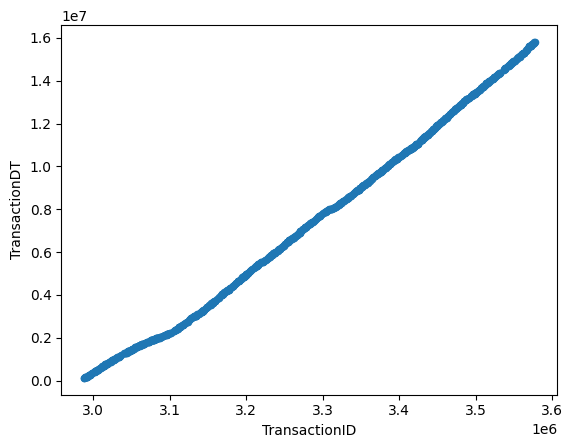

In [25]:
train.sample(1000).plot.scatter(x='TransactionID', y='TransactionDT')

# Helper Functions

In [7]:
# save model, loss plot, gain plot, and create submission. Submission is averaged later for final submission.
def log_training(model, run_num):

    fold_num=0
    while os.path.exists('experiments/run%s/lossplot%s.png' % (run_num, fold_num) ):
        fold_num+=1

    # Get results
    results         = model.evals_result()
    gain            = model.get_booster().get_score(importance_type='gain')

    # Get top 15 features as measured by gain score for plot generation
    gain_sorted     = dict(sorted(gain.items(), key=lambda item: item[1]))
    keys            = list(gain_sorted.keys())[0:15]
    values          = list(gain_sorted.values())[0:15]

    # Log gain in json - use later to get all features from model and top N
    with open('experiments/run%s/gain%s.json' % (run_num, fold_num), "w+") as json_file:
        json.dump(gain_sorted, json_file)
    
    # Create gain plot
    plt.figure(figsize=(20,6))
    plt.bar(keys, values, color='skyblue')
    plt.xlabel('Keys')
    plt.ylabel('Values')
    plt.title('Dictionary Plot')
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--')
    plt.savefig('experiments/run%s/gainplot%s.png' % (run_num, fold_num) )

    # Create loss plot
    plt.figure(figsize=(10,7))
    plt.plot(results['validation_0']['auc'], label='Training AUC')
    plt.plot(results['validation_1']['auc'], label='Validation AUC')
    plt.title('Loss: run %s, split %s' % (run_num, fold_num))
    plt.xlabel("Number of trees")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig('experiments/run%s/lossplot%s.png' % (run_num, fold_num) )

    # Save model
    with open('experiments/run%s/model%s.pkl' % (run_num, fold_num), mode='wb+') as file:
        pickle.dump(model, file)

# Training 

In [ ]:
###########################
###### OPTIONS ############
###########################
category_enc    = True
target_enc      = True
dim_red         = False
wgt_avg         = False
drop_low_gain   = False
sample_wgts     = False

submission      = True
############################


# Create directory
run_num=0
while os.path.exists('experiments/run%s' % run_num):
    run_num+=1
os.mkdir('experiments/run%s' % run_num)

# Get data
X                   = train.copy(deep=True)
y                   = train['isFraud'].copy(deep=True)
num_splits          = 5

# For submission generation
if submission:
    sample_submission   = pd.read_csv('data/sample_submission.csv')
    test_identity       = pd.read_csv('data/test_identity.csv')
    test_transaction    = pd.read_csv('data/test_transaction.csv')
    test                = test_transaction.merge(test_identity, on='TransactionID', how='outer')
    test.rename( columns = lambda x: x.replace('id-', 'id_'), inplace=True )

model_kwargs = {
    'max_depth':                8,  
    'subsample':                0.8,  
    'n_estimators':             2000,  
    'learning_rate':            0.05,
    'enable_categorical':       True,
    'eval_metric':              'auc',
    'tree_method':              'hist',
    'device':                   'cuda',
    'objective':                'binary:logistic'
}

if not submission:
    model_kwargs.update( {'early_stopping_rounds': 50} )

model = XGBClassifier( **model_kwargs )

final_AUC_train = []
final_AUC_test = []


kf = KFold(n_splits=num_splits)
for fold_num, (train_index, val_index) in enumerate(kf.split(X)):
    fit_kwargs = {}

    # When not generating submission, use 5-fold validation.
    if not submission:
        X_train     = X.iloc[train_index]
        X_test      = X.iloc[val_index]
        y_train     = y.iloc[train_index]
        y_test      = y.iloc[val_index]

    # On submission generation, train on entire training set.
    if submission:
        X_train     = X
        y_train     = y    
        X_test      = test

    ###########################
    ### FEATURE ENGINEERING ###
    ###########################

    ### SAMPLE WEIGHTS ###
    if sample_wgts:
        sample_weight = compute_sample_weight( class_weight='balanced',  y=y_train )
        fit_kwargs.update({'sample_weight' : sample_weight})

    ### CATEGORY ENCODING ###
    if category_enc:
        X_train[CATEGORIES]     = X_train[CATEGORIES].astype('category').apply(lambda x: x.cat.codes)
        X_test[CATEGORIES]      = X_test[CATEGORIES].astype('category').apply(lambda x: x.cat.codes)

    ### DROP LOWER HALF OF GAIN SCORERS ###
    if drop_low_gain:
        with open('experiments/run%s/gain%s.json' % (19, 0), "rb") as file:
            gain = json.load(file)
        
        gain_sorted     = dict(sorted(gain.items(), key=lambda item: item[1]))
        drop            = list( gain_sorted.keys() )[int(-1 * len(gain_sorted)/2 ):-1]
        X_train.drop(columns=drop, inplace=True)
        X_test.drop(columns=drop, inplace=True)

    ### WEIGHTED AVERAGE ###
    # The weighted average is the average of the top 15 features measured by gain importance weighted by their gain score.
    if wgt_avg:
        gain = {}
        for i in range(0,5):
            with open('experiments/run%s/gain%s.json' % (12, i), "rb") as file:
                gain.update( json.load(file) ) 

        gain_sorted     = dict(sorted(gain.items(), key=lambda item: item[1]))
        features        = np.array( list( gain_sorted.keys() )[0:15] )
        gain_scores     = np.array( list( gain_sorted.values() )[0:15] )

        X_train['weighted_avg'] = X_train[features].fillna(0).dot( gain_scores.transpose() ).div( gain_scores.dot( gain_scores.transpose() ))
        X_test['weighted_avg']  = X_test[features].fillna(0).dot( gain_scores.transpose() ).div( gain_scores.dot( gain_scores.transpose() ))
        

    ### TARGET ENCODING ###
    if target_enc:

        STATS = ['count']
        for (name, cls) in FEATURE_CLASSES.items():
            agg_features            = X_train.groupby(cls).isFraud.agg(STATS)
            agg_features.columns    = [f"TE_{name}_{s}" for s in STATS]

            X_train = X_train.merge(agg_features, on=cls, how='left')
            X_test  = X_test.merge(agg_features, on=cls, how='left')

    ### PCA ### 
    # PCA is conducted within feature category. (e.g. V's are compared against V's for correlation.)
    if dim_red:
        mean_imp    = SimpleImputer(missing_values=np.nan, strategy='mean').set_output(transform='pandas')
        pca         = PCA(n_components=0.99, svd_solver='full').set_output(transform='pandas')

        for (name, cls) in FEATURE_CLASSES.items():
            cls_nums = [x for x in cls if x not in CATEGORIES and x not in NA05]

            if len(cls_nums) > 1:
                # For features that are missing fewer than 5% of values, we impute with the mean.
                mean_imp.fit(X_train[cls_nums])
                X_train[cls_nums]   = mean_imp.transform(X_train[cls_nums])
                X_test[cls_nums]    = mean_imp.transform(X_test[cls_nums])
                
                pca.fit(X_train[cls_nums])
                X_train             = pd.concat([X_train, mean_imp.transform(X_train[cls_nums])], axis=1)
                X_test              = pd.concat([X_test, mean_imp.transform(X_test[cls_nums])], axis=1)

                X_train.drop(columns=cls_nums, inplace=True)
                X_test.drop(columns=cls_nums, inplace=True)
    

    X_train.drop(columns='isFraud', inplace=True)
    try:
        X_test.drop(columns='isFraud', inplace=True)
    except KeyError:
        pass
    
    # X_train     = feature_engineering( X_train,  split = 'train',  **FE_kwargs)
    # X_val       = feature_engineering( X_val, split='val', **FE_kwargs)

    

    if not submission:
        fit_kwargs.update({'eval_set' : [(X_train, y_train), (X_test, y_test)]})

    model.fit( X_train, y_train, **fit_kwargs ) 


    if not submission:
        # Get AUC training and validation scores
        log_training(model, run_num)
        results = model.evals_result()
        final_AUC_train.append( results['validation_0']['auc'][-1] )
        final_AUC_test.append( results['validation_1']['auc'][-1] )

    if submission:
        #Generate submission and exit
        sample_submission['isFraud'] = model.predict_proba(X_test)[:,1]
        sample_submission.to_csv(f'experiments/run{run_num}/submission.csv', index=False)
        break

if not submission:
    # Update spreadsheet with run scores so far
    mean_train_AUC  = sum(final_AUC_train) / len(final_AUC_train)
    mean_val_AUC    = sum(final_AUC_test) / len(final_AUC_test)
    print('Average errors: Training %s, Validation %s' % (mean_train_AUC, mean_val_AUC ))
    current_scores = pd.DataFrame()
    current_scores['run'] = [run_num]
    current_scores['mean_train_AUC'] = [mean_train_AUC]
    current_scores['mean_val_AUC'] = [mean_val_AUC]
    scores = pd.read_csv('experiments/average_scores.csv')
    scores = pd.concat([scores, current_scores])
    scores.to_csv('experiments/average_scores.csv', index=False)

c:\Users\19368\anaconda3\envs\Kaggle\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:14:56] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


# Junkyard

In [8]:
###############################################################################################
# REMOVED - Feature engineering no longer handled via function.
# FE_kwargs = {
#     'target_encoding':      True,
#     'category_encoding':    True,
#     'dimension_reduction':  True,
#     'weighted_average':     False
# }

# def feature_engineering(df, split, **kwargs):
#     fold_num        = kwargs.get('fold_num')
#     run_num         = kwargs.get('run_num')
#     target_enc      = kwargs.get('target_encoding')
#     category_enc    = kwargs.get('category_encoding')
#     dim_red         = kwargs.get('dimension_reduction')
#     # wt_avg          = kwargs.get('weighted_average')

#     ### CATEGORY ENCODING ###
#     if category_enc:
#         df[CATEGORIES] = df[CATEGORIES].astype('category').apply(lambda x: x.cat.codes)

#     ### TRAINING ###
#     if split == 'train':
        
#         ### TARGET ENCODING ###
#         if target_enc:

#             STATS = ['sum']
#             for (name, cls) in FEATURE_CLASSES.items():
#                 agg_features = df.groupby(cls).isFraud.agg(STATS)
#                 agg_features.columns = [f"TE_{name}_{s}" for s in STATS]
#                 df = df.merge(agg_features, on=cls, how='left')

#         print(df.select_dtypes(exclude=np.number))

#         ### PCA DIMENSIONALITY REDUCTION ### 
#         if dim_red:
#             mean_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#             pca = PCA(n_components=0.99, svd_solver='full')
#             pca.set_output(transform='pandas')
#             for (name, cls) in FEATURE_CLASSES.items():
#                 cls_nums = [x for x in cls if x not in CATEGORIES and x not in NA05]

#                 if len(cls_nums) > 1:
#                     df[cls_nums] = mean_imp.fit_transform(df[cls_nums])
#                     tmp = pca.fit_transform(df[cls_nums])
#                     tmp.columns = [f'PCA_{name}_{i}' for i in range(len(tmp.columns))]
#                     df = pd.merge(df, tmp, left_index=True, right_index=True, how='left') 
#                     df.drop(columns=cls_nums, inplace=True)


#         df.drop(columns=['isFraud']).to_pickle('experiments/run%s/X_train_%s.pkl' % (run_num, fold_num))
    
#     ### VALIDATION ###
#     elif split == 'val':
#         trained = pd.read_pickle('experiments/run%s/X_train_%s.pkl' % (run_num, fold_num))
#         diff_cols = trained.columns.difference(df.columns)
#         df = pd.merge(df, trained[diff_cols])
#         #df = pd.merge(df.groupby(CATEGORIES), trained[diff_cols].groupby(CATEGORIES), left_index=True, right_index=True, how='left')
    

#     ### TESTING ###
#     elif split == 'test':
#         trained = []
#         for i in range(5):
#             trained.append(pd.read_pickle('experiments/run%s/X_train_%s.pkl' % (run_num, i)))
        
        
#         averages = pd.concat(trained).groupby('TransactionID').mean()
#         diff_cols = trained[0].columns.difference(df.columns)
#         df = pd.merge(df, averages[diff_cols], left_index=True, right_index=True, how='left')
#         #df = pd.concat([df, averages], axis=1)

#     try:
#         df.drop(columns=['isFraud'], inplace=True)
#     except KeyError:
#         pass

#     return df
###############################################################################################



################################################################################################
# MOVED - Feature engineering now handled within training block.
# # dimensionality reduction within each feature class
# def pca_reductions(df):
#     pca = PCA(n_components=0.99, svd_solver='full')
#     pca_count = 0
#     for cls in FEATURE_CLASSES.values():
#         cls_nums = [x in cls if x in NUMBERS]
#         df[f'PCA_{pca_count}'] = pca.fit(df[cls_nums])

# # encodes non-numeric values as numeric
# def encode_categories(df):
#     df[CATEGORIES] = df[CATEGORIES].astype('category').apply(lambda x: x.cat.codes)
#     return df

# # target encoding
# def target_encoding(df):
#     STATS = ['mean']
#     agg_features = df.groupby(CARD).isFraud.agg(STATS)
#     agg_features.columns = [f"TE_CARD_{s}" for s in STATS]
#     df = df.merge(agg_features, on=CARD, how='left')
#     return df


        

# # adds average of features, weighted by relative gain importance
# def add_weighted_avg(data, feature_list_dict):
#     for k,v in feature_list_dict.items():
#         features = data[v]
#         gain = gain_sub3[v]
#         data[k] = features.fillna(0).dot( gain.transpose() ).div( gain.dot( gain.transpose() ))

# # adds quadratic terms in top n features: e.g. x_1, x_2, x_3 are added as x_1 **2, x_1 * x_2, x_1 * x_3, ..., x_2 * x_3. 
# # using n features adds 2 * (n choose 2)new features.
# def add_products(data, feature_list):
#     pairs = list(itertools.product(feature_list, feature_list))
#     for pair in pairs:
#         data[str(pair[0] + "*" + pair[1])] = data[pair[0]] * data[pair[1]]
################################################################################################



################################################################################################
# MOVED - Submission generation now handled within training block.
# create submission as csv - predictions are created as mean across each model 
# def generate_submission(run_num):

#     sample_submission   = pd.read_csv('data/sample_submission.csv')
#     test_identity       = pd.read_csv('data/test_identity.csv')
#     test_transaction    = pd.read_csv('data/test_transaction.csv')
#     test                = test_transaction.merge(test_identity, on='TransactionID', how='outer')

#     test.rename( columns = lambda x: x.replace('id-', 'id_'), inplace=True )

#     test = feature_engineering(test, run_num=run_num, split='test', category_encoding=True)

#     df = pd.DataFrame()
#     model_list = glob.glob('experiments/run%s/model*.pkl' % run_num)
#     for i, model in enumerate(model_list):
#         df[i] = pickle.load(open(model, "rb")).predict_proba(test)[:,1]

#     sample_submission['isFraud'] = df.mean(axis=1)
#     del df
#     sample_submission.to_csv('submissions/submission_run%s.csv' % run_num, index=False)
#####################################################################################################